In [1]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np
from river import evaluate
from river import optim
import datetime as dt

c:\Users\stijn\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


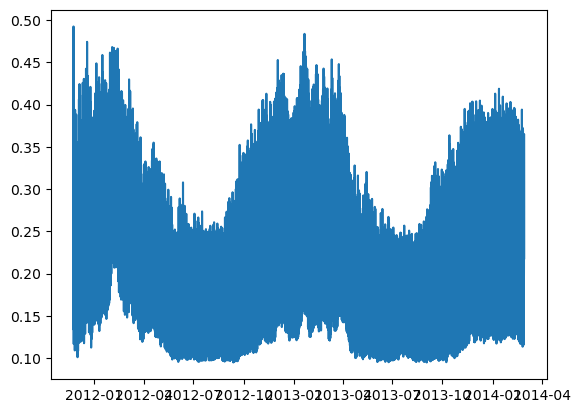

In [2]:
# Load the data
df = pd.read_csv('merged_data.csv')


# Convert the 'utc_timestamp' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Drop the first row
df = df.dropna()

df['day_of_week'] = df['DateTime'].dt.dayofweek
df['hour_of_day'] = df['DateTime'].dt.hour
df['month'] = df['DateTime'].dt.month

#mean energy consumption addive so that the model can learn the trend


#plot the data
plt.plot(df['DateTime'], df['MeanEnergyConsumption'])

In [3]:
#check for break in timestamps
import pandas as pd

# Assuming df is your DataFrame and 'timestamp' is your timestamp column
df = df.sort_values('DateTime')

# Calculate the difference between current and previous timestamp
df['time_diff'] = df['DateTime'].diff()

# Define a threshold for a break, e.g., 1 hour
threshold = pd.Timedelta(hours=1)

# Check if there are any breaks
has_breaks = any(df['time_diff'] > threshold)

print(f"Data has breaks: {has_breaks}")

Data has breaks: False


In [10]:
#df['MeanEnergyConsumption'].plot()

#drop the utc_timestamp column
#df = df.drop('utc_timestamp', axis=1)

stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
print(next(stream))

({'DateTime': Timestamp('2011-11-23 09:00:00'), 'temperature_2m': 4.25, 'precipitation': 0.0, 'cloud_cover': 30.300001, 'cloud_cover_low': 1.0, 'cloud_cover_mid': 0.0, 'cloud_cover_high': 98.0, 'is_day': 1.0, 'sunshine_duration': 2924.7007, 'day_of_week': 2, 'hour_of_day': 9, 'month': 11, 'time_diff': NaT}, 0.355)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from river import neural_net



# Create a pipeline that includes scaling the target variable
model = compose.Pipeline(
    compose.Select('hour_of_day', 'month', 'day_of_week','temperature_2m', 'precipitation','cloud_cover','cloud_cover_low','cloud_cover_mid','cloud_cover_high','is_day','sunshine_duration'),
    preprocessing.StandardScaler(),
    preprocessing.TargetStandardScaler(
        regressor=neural_net.MLPRegressor(
            hidden_dims=(128,64),
            activations=(neural_net.activations.ReLU(),#Input layer
                         neural_net.activations.ReLU(), 
                        neural_net.activations.ReLU(), 

                         neural_net.activations.ReLU(), #output layer
                         ),
            optimizer=optim.Adam(lr=0.00001),
            seed=42
        )
    )
)

# Evaluate the model
steps = evaluate.iter_progressive_val_score(
    dataset=stream,
    model=model,
    metric=metrics.RMSE(),
    moment='DateTime',
    delay=dt.timedelta(days=7),
    step=1,
    yield_predictions=True,
)

start_date =  df['DateTime'].min()
end_date =  df['DateTime'].max()
# Initialize lists to store the predictions and their timestamps
predictions = []
timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')
#remove the first timestamp
timestamps = timestamps[2:]
Mea_overtime = []
print(steps)
length = 0

for step in steps:
    
    length += 1
    predictions.append(step["Prediction"])
    Mea_overtime.append(str(step["RMSE"]).split(" ")[1])
print(step)



<generator object iter_progressive_val_score at 0x0000014F0F805000>
{'RMSE': RMSE: 0.073168, 'Step': 19863, 'Prediction': 0.21985250557952368}


C:\Users\stijn\AppData\Local\Temp\ipykernel_16596\3540767118.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(df['DateTime']), df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
C:\Users\stijn\AppData\Local\Temp\ipykernel_16596\3540767118.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')


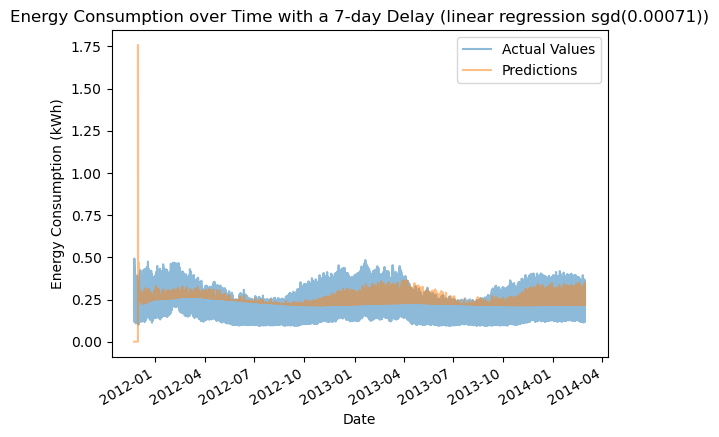

C:\Users\stijn\AppData\Local\Temp\ipykernel_16596\3540767118.py:40: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')
C:\Users\stijn\AppData\Local\Temp\ipykernel_16596\3540767118.py:43: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')


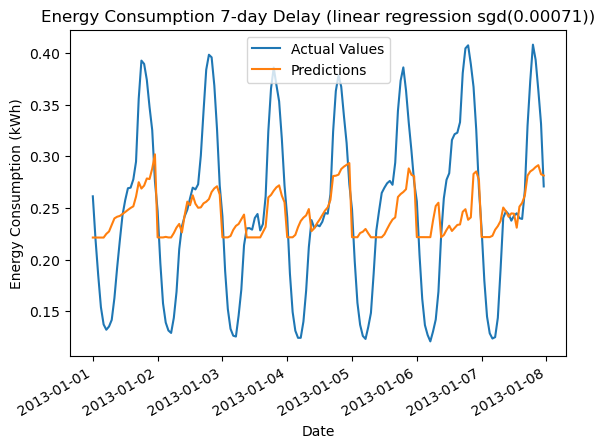

In [12]:




# Plot the predictions
fig, ax = plt.subplots()
#drop one value from predictions
predictions = predictions[1:]

# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(df['DateTime']), df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')
ax.set_title('Energy Consumption over Time with a 7-day Delay (linear regression sgd(0.00071))')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.legend()
plt.show()


#plotting of the predictions and actual values for a week

# Define the start and end dates



start_date = pd.to_datetime('2013-01-01')
end_date = start_date + pd.DateOffset(weeks=1)
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter the data
week_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < end_date)]

#combine the predictions and timestamps into a dataframe
df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

#convert datetime to datetime object
df_prediction['DateTime'] = pd.to_datetime(df_prediction['DateTime'])
week_predictions = df_prediction[(df_prediction['DateTime'] >= start_date) & (df_prediction['DateTime'] < end_date)]
fig, ax = plt.subplots()

# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')

# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Energy Consumption 7-day Delay (linear regression sgd(0.00071))')

# Rotate date labels automatically
fig.autofmt_xdate()

plt.show()
